In [4]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

ERROR:root:The 'ast_node_interactivity' trait of a Shell instance must be any of ['all', 'last', 'last_expr', 'none'], but a value of 'last_expr_or_assign' <class 'str'> was specified.


# Mars Satellite Flight:
###What Is the minimum energy needed to launch a rocket for a Satellite to reach orbit around Mars
By Robin Graham-Hayes and Theo Johnson

links: 
https://en.wikipedia.org/wiki/McDonnell_Douglas_DC-X
http://www.astronautix.com/d/dc-x.html
https://en.wikipedia.org/wiki/Thrust

Situation:

In the future, it is possible that space missions will be launched from Mars. Not only is this more convenient because it is further into the solar system than Earth, it also has a smaller gravity field. This could lead to the emergence of one-stage rockets, namely ion rockets, as they require less energy to launch.

Question:

This presented us with the question: What launch conditions for an ion rocket on Mars requires the minimum amount of energy to result in an orbit around Mars.

Method:

A rocket would require the least energy when it uses the least amount of thrust. To find where the rocket needs the lowest thrust, we decided to sweep the launch angle and thrust in order to find what scenario produces an orbiting rocket with the lowest thrust.


Creating our Model:

First, we started my making our system and state. For our state, we started with the rocket stationary on the surface of Mars meaning our velocities and x were 0 and our y was 3389000 meters, the radius of Mars. This also made our gravitational force equivalent to the gravitational constant of Mars. Our system included the mass of the rocket, obtained from the Wikipedia page on the McDonnell Douglas DC-X, an one-stage rocket. It also includes the mass of Mars, the gravitational constant on Mars, and the C_d value of the rocket.

In [0]:
init = State(
    x=0,
    y=3389500, #m,
    vx=0,
    vy=0,

)   




In [0]:
system = System(
    init=init,   
    mars_mass= 6.39E23, #kg
    mass_rocket=18900, #kilograms
    area=np.pi * (4.1/2)**2,
    C_d= .5,
    G=6.674E-11,
    t_0 = 0,
    t_end=2400,
    thrust_hat=Vector(1,100).hat(),
    thrust=Vector(1,100).hat()*1000000
    )

For our drag force function, we used the same equation as we did in our notebook. It takes in the atmospheric pressure, the velocity, the C_d, and the area and returns the force from drag which is used later to calculate the total external force on the rocket.

In [0]:
def drag_force(state, V, system):
  
    unpack(system)
    mag = -pressure(state,system) * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

To find our gravitational force, we used the universal_gravitation function from our orbital mechanics notebook, replacing the sun with Mars and Earth with the rocket. This returns a force which is used to find the total external force on the rocket.

In [0]:
def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy= state
    unpack(system)
    
    v = Vector(vx,vy)
    d = Vector(x,y)
   
    force_mag = G * mass_rocket * mars_mass / (d.mag)**2
    
    force = d.hat() * force_mag
    
    return force

Our pressure function updates pressure according to the Mars atmospheric pressure equation found on NASA's website. It takes in the rocket's distance from the center of Mars and returns the pressure at that height.

In [0]:
def pressure(state,system):
  x, y, vx, vy= state
  unpack(system)
  d = Vector(x,y)
  p=.699*exp(-.00009*d.mag)
  return p

In [0]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(state, V, system) / mass_rocket
    a_grav = -universal_gravitation(state, system)
    a_rocket = Vector(system.thrust.x, system.thrust.y).mag / mass_rocket
    
    a = a_grav + a_drag + a_rocket
    
    return vx, vy, a.x, a.y

Our event function causes a stop when the rocket is perpendicular to Mars, this is when the rocket would be in position to cut off thrust and be in orbit. 

In [0]:

def event_func(state, t, system):
    unpack(system)
    x, y, vx, vy= state
    
    V=Vector(vx,vy)
    
    return V.angle - (((pi/2)-1.4909663410826592) + universal_gravitation(state, system).angle)

In [27]:
event_func(init, 0, system)
slope_func(init, 0, system)

(0,
 0,
 <Quantity(52.91005291005292, 'dimensionless')>,
 <Quantity(-70105.1526417253, 'dimensionless')>)

In [28]:
  
results1, details1 = run_ode_solver(system, slope_func, events=event_func, method='RK45')
results1

,x,y,vx,vy
0.000000e+00,0.000000e+00,3.389500e+06,0.000000e+00,0.000000e+00
1.426428e-08,5.382798e-15,3.389500e+06,7.547240e-07,-9.999997e-04
1.569071e-07,6.513185e-13,3.389500e+06,8.301963e-06,-1.100000e-02
1.583335e-06,6.632145e-11,3.389500e+06,8.377436e-05,-1.110000e-01
1.584762e-05,6.644100e-09,3.389500e+06,8.384983e-04,-1.111000e+00
1.584904e-04,6.645297e-07,3.389500e+06,8.385738e-03,-1.111100e+01
1.584919e-03,6.645416e-05,3.389500e+06,8.385813e-02,-1.111110e+02
1.584920e-02,6.645425e-03,3.389491e+06,8.385814e-01,-1.111113e+03
1.584920e-01,6.645141e-01,3.388619e+06,8.385095e+00,-1.111303e+04
1.584920e+00,6.615763e+01,3.300671e+06,8.309806e+01,-1.130937e+05


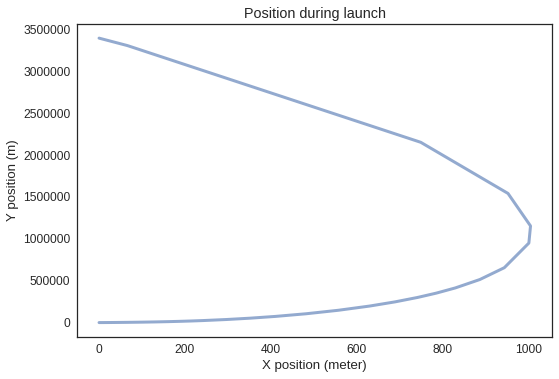

In [29]:
plot(results1.x,results1.y)
decorate(xlabel='X position (meter)',
         ylabel='Y position (m)',
         title='Position during launch',
         legend=False)


Here we create a function to determine final heigths based off of a given value for thust:




In [0]:
def range_func(thrust, system):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    state = State(system.init, thrust=thrust*system.thrust_hat)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.x)
    y_dist = get_last_value(results.y)
    d = Vector(x_dist,y_dist)
    return d.mag

Now we sweep through values of thrust:

In [0]:
thrusts = linspace(10, 8000000, 100)
sweep = SweepSeries()

for thru in thrusts:
    dis = range_func(thru, system)
    #print(thru, dis)
    sweep[thru] = dis

And plot our final results:

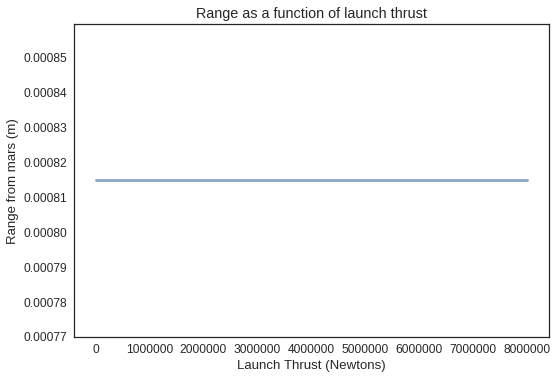

In [17]:
plot(sweep)
decorate(xlabel='Launch Thrust (Newtons)',
         ylabel='Range from mars (m)',
         title='Range as a function of launch thrust',
         legend=False)

Abstract: 

In this project, we asked: what is the optimal launch angle and thrust are to minimize energy when launching a rocket into orbit on Mars?

In [0]:
# Imports
from IPython.display import clear_output
import os
import time

# Install Python libraries
!pip3 install pandas seaborn sympy beautifulsoup4 lxml pint scipy==1.1.0 numpy

# Removes code before re-downloading it
!rm -rf ./ModSimPy
!rm -rf ./modsim.py

# Grabs ModSimPy
!git clone https://github.com/AllenDowney/ModSimPy.git
!cp "ModSimPy/code/modsim.py" .

# Resets kernel to flush outdated libraries (especially SciPy)
clear_output()
print("Configured for ModSimPy. Restarting kernel.")
time.sleep(1)
os._exit(0)

Configured for ModSimPy. Restarting kernel.
